# Preprocess data and generate figures

## General imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from glob import glob
from pathlib import Path
from utils import find_datasets
from scipy import integrate

In [11]:
half_width = 3.33
full_width = 6.84
save_fig = True

In [12]:
import matplotlib.colors as mcolors

colors = [
    (136, 204, 238),
    (68, 170, 153),
    (17, 119, 51),
    (153, 153, 51),
    (221, 204, 119),
    (204, 102, 119),
    (136, 34, 85),
    (170, 68, 153),
]

colors = [mcolors.rgb2hex(np.array(c) / 255) for c in colors]

## Load data and preprocess

In [13]:
results_dir = Path("data/results")

In [14]:
model_names = {
    "pfn": "TabPFN",
    "xgb_default": "XGBoost",
    "gluon_best": "AutoGluon$^+$",
    "gluon_medium": "AutoGluon$^\sim$",
    "bo_xgb": "XGBoost$^\\ast$",
    "bo_svm": "SVM$^\\ast$",
    "bo_knn": "KNN$^\\ast$",
    "bo_decision_trees": "DT$^\\ast$",
}

dataset_names = {
    "airfoil_cl": "Airfoil binary",
    "airfoil_cl_m": "Airfoil multi-class",
    "framed_validity": "FRAMED validity",
    "framed_safety": "FRAMED safety",
    "solar_hex": "Solar HEX",
    "truss_6d": "3-bar truss",
    "welded_beam": "Welded beam",
    "welded_beam_balanced": "Welded beam (+)",
}

datasets = list(dataset_names.keys())

In [15]:
results = []
for d in datasets:
    for f in glob((results_dir / d / "*.parquet").as_posix()):
        results.append(pd.read_parquet(f))


results = pd.concat(results, axis=0)

results["total_time"] = results["train_time"] + results["test_time"]

In [16]:
models = results.model.unique()

In [17]:
dataset_sizes = (
    results[results.trainset_fraction >= 1.0]
    .groupby(["dataset"])
    .trainset_size.unique()
    .apply(lambda x: x[0])
)
dataset_sizes

dataset
airfoil_cl               886
airfoil_cl_m             886
framed_safety           3236
framed_validity         3609
solar_hex                500
truss_6d                1000
welded_beam             2000
welded_beam_balanced    2500
Name: trainset_size, dtype: int64

## Statistical Analysis

In [18]:
from tabular.analysis import performance_analysis, graph_ranks

/home/cyrilp/Documents/Work/pfn/classification-study/tabular/analysis.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: f"{x[0]}-{x[1]}-{np.round(x[2], 2)}", axis=1


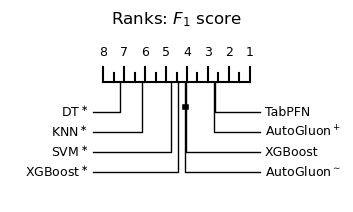

In [19]:
average_ranks, p_values = performance_analysis(
    results.loc[results.model.isin(model_names.keys())], field="f1"
)
ax = graph_ranks(
    average_ranks.values,
    average_ranks.keys(),
    model_names,
    p_values,
    cd=None,
    reverse=True,
    textspace=0.28,
    labels=False,
)
ax.set_title("Ranks: $F_1$ score")

if save_fig:
    ax.get_figure().savefig(
        "figures/critical_difference_all_datasets.pdf", bbox_inches="tight"
    )
    ax.get_figure().savefig(
        "figures/critical_difference_all_datasets.eps", bbox_inches="tight"
    )

/home/cyrilp/Documents/Work/pfn/classification-study/tabular/analysis.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: f"{x[0]}-{x[1]}-{np.round(x[2], 2)}", axis=1


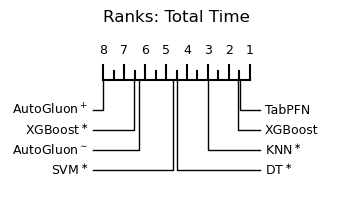

In [20]:
average_ranks, p_values = performance_analysis(
    results.loc[results.model.isin(model_names.keys())], field="total_time", ascending=True
)
ax = graph_ranks(
    average_ranks.values,
    average_ranks.keys(),
    model_names,
    p_values,
    cd=None,
    reverse=True,
    textspace=0.28,
    labels=False,
)
ax.set_title("Ranks: Total Time")
if save_fig:
    ax.get_figure().savefig(
        "figures/critical_difference_speed_all_datasets.pdf", bbox_inches="tight"
    )
    ax.get_figure().savefig(
        "figures/critical_difference_speed_all_datasets.eps", bbox_inches="tight"
    )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


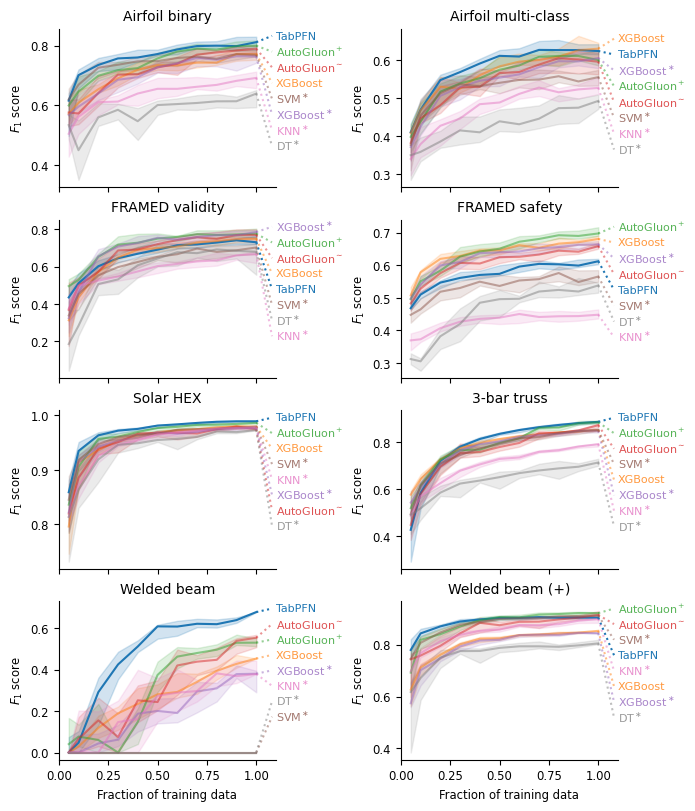

In [25]:
with mpl.rc_context(
    {
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
):
    field = "f1"
    fig, axs = plt.subplots(
        4, 2, figsize=(full_width, 8), sharex=True, sharey=False, layout="constrained",
    )
    for i, dataset in enumerate(dataset_names.keys()):
        ax = axs.flat[i]
        l_data = results.loc[
            results.model.isin(model_names.keys()) & results.dataset.isin([dataset])
        ]
        shown_models = set(["pfn"])

        sns.lineplot(
            data=l_data,
            x="trainset_fraction",
            y=field,
            estimator="median",
            errorbar=("ci", 95),
            ax=ax,
            hue="model",
            legend=False,
            hue_order=model_names.keys(),
        )

        for m, l, c in zip(model_names.keys(), ax.lines, ax.collections):
            if m not in shown_models:
                # print(c.get_alpha(), l.get_alpha())
                l.set_alpha(0.5)
                c.set_alpha(0.15)

        ax.set_xlabel("Fraction of training data")
        ax.set_ylabel("$F_1$ score")
        ax.set_title(dataset_names[dataset])
        ax.set_xlim(0.0, 1.1)

        y_min, y_max = ax.get_ylim()
        y_range = y_max - y_min
        y_mid = 0.5 * (y_max + y_min)
        sep = y_range / 10

        final_values = (
            l_data.loc[l_data.trainset_fraction == 1.0]
            .groupby("model")[field]
            .median()
            .sort_values(ascending=False)
            .copy()
        )

        theoretical_values = pd.Series(
            0.5 * (y_max + final_values.iloc[0]) - np.arange(len(final_values)) * sep,
            index=final_values.index,
            name="theoretical",
        )

        merged_values = pd.concat([final_values, theoretical_values], axis=1).loc[
            model_names.keys()
        ]

        for j, (k, v) in enumerate(merged_values.iterrows()):
            ax.plot([1.0, 1.08], [v[field], v.theoretical], c=f"C{j}", linestyle=":", alpha=(0.5+0.5*(k=="pfn")))
            ax.text(
                1.1,
                v.theoretical,
                model_names[k],
                ha="left",
                va="center",
                size=8,
                color=f"C{j}",
                alpha=(0.8+0.2*(k=="pfn")),
            )

    sns.despine()

    if save_fig:
        fig.savefig("figures/f1_vs_trainset_fraction_all.pdf", bbox_inches="tight")
        fig.savefig("figures/f1_vs_trainset_fraction_all.eps", bbox_inches="tight")

plt.show()

In [26]:
# Table

summary_table = results.loc[
    results.model.isin(model_names.keys()) & results.trainset_fraction.round(2).isin([0.1, 0.5, 1.0])
].groupby(["dataset", "model", "trainset_fraction"]).f1.agg(["mean", "std"]).reset_index()

summary_table["trainset_fraction"] = summary_table.trainset_fraction.round(2)
summary_table["mean"] = summary_table["mean"].round(3)
summary_table["std"] = summary_table["std"].round(3)

summary_table["Performance"] = summary_table["mean"].apply(lambda x: f"{x:.3f}") + " \pm " + summary_table["std"].apply(lambda x: f"{x:.3f}") 
summary_table = summary_table.drop(columns=["mean", "std"])

In [27]:
t1_lx = summary_table.loc[summary_table.trainset_fraction == 0.1].drop(
    columns=["trainset_fraction"]
).replace({'model': model_names, 'dataset': dataset_names}).set_index("model").pivot(columns="dataset", values="Performance").loc[model_names.values(), dataset_names.values()].style.format(lambda x: f"${x}$").to_latex()

print(t1_lx)

\begin{tabular}{lllllllll}
dataset & Airfoil binary & Airfoil multi-class & FRAMED validity & FRAMED safety & Solar HEX & 3-bar truss & Welded beam & Welded beam (+) \\
model &  &  &  &  &  &  &  &  \\
TabPFN & $0.685 \pm 0.073$ & $0.468 \pm 0.039$ & $0.514 \pm 0.076$ & $0.510 \pm 0.017$ & $0.930 \pm 0.028$ & $0.529 \pm 0.184$ & $0.094 \pm 0.122$ & $0.840 \pm 0.045$ \\
XGBoost & $0.606 \pm 0.068$ & $0.461 \pm 0.043$ & $0.418 \pm 0.088$ & $0.573 \pm 0.028$ & $0.894 \pm 0.034$ & $0.638 \pm 0.036$ & $0.049 \pm 0.066$ & $0.696 \pm 0.064$ \\
AutoGluon$^+$ & $0.642 \pm 0.075$ & $0.445 \pm 0.071$ & $0.535 \pm 0.069$ & $0.555 \pm 0.032$ & $0.901 \pm 0.041$ & $0.595 \pm 0.084$ & $0.093 \pm 0.088$ & $0.804 \pm 0.044$ \\
AutoGluon$^\sim$ & $0.576 \pm 0.095$ & $0.448 \pm 0.056$ & $0.493 \pm 0.075$ & $0.525 \pm 0.030$ & $0.877 \pm 0.062$ & $0.535 \pm 0.114$ & $0.108 \pm 0.126$ & $0.726 \pm 0.114$ \\
XGBoost$^\ast$ & $0.593 \pm 0.074$ & $0.434 \pm 0.044$ & $0.480 \pm 0.108$ & $0.551 \pm 0.029$ & $0.

In [28]:
t2_lx = summary_table.loc[summary_table.trainset_fraction == 0.5].drop(
    columns=["trainset_fraction"]
).replace({'model': model_names, 'dataset': dataset_names}).set_index("model").pivot(columns="dataset", values="Performance").loc[model_names.values(), dataset_names.values()].style.format(lambda x: f"${x}$").to_latex()

print(t2_lx)

\begin{tabular}{lllllllll}
dataset & Airfoil binary & Airfoil multi-class & FRAMED validity & FRAMED safety & Solar HEX & 3-bar truss & Welded beam & Welded beam (+) \\
model &  &  &  &  &  &  &  &  \\
TabPFN & $0.777 \pm 0.027$ & $0.604 \pm 0.033$ & $0.695 \pm 0.038$ & $0.582 \pm 0.027$ & $0.980 \pm 0.004$ & $0.834 \pm 0.015$ & $0.582 \pm 0.067$ & $0.904 \pm 0.011$ \\
XGBoost & $0.727 \pm 0.034$ & $0.589 \pm 0.038$ & $0.697 \pm 0.044$ & $0.644 \pm 0.020$ & $0.968 \pm 0.007$ & $0.811 \pm 0.014$ & $0.275 \pm 0.088$ & $0.824 \pm 0.013$ \\
AutoGluon$^+$ & $0.756 \pm 0.041$ & $0.584 \pm 0.039$ & $0.758 \pm 0.045$ & $0.653 \pm 0.026$ & $0.975 \pm 0.007$ & $0.798 \pm 0.020$ & $0.378 \pm 0.097$ & $0.905 \pm 0.013$ \\
AutoGluon$^\sim$ & $0.727 \pm 0.042$ & $0.567 \pm 0.043$ & $0.714 \pm 0.070$ & $0.624 \pm 0.023$ & $0.962 \pm 0.016$ & $0.775 \pm 0.030$ & $0.286 \pm 0.160$ & $0.871 \pm 0.041$ \\
XGBoost$^\ast$ & $0.718 \pm 0.043$ & $0.556 \pm 0.044$ & $0.752 \pm 0.037$ & $0.637 \pm 0.023$ & $0.

In [29]:
t3_lx = summary_table.loc[summary_table.trainset_fraction == 1.0].drop(
    columns=["trainset_fraction"]
).replace({'model': model_names, 'dataset': dataset_names}).set_index("model").pivot(columns="dataset", values="Performance").loc[model_names.values(), dataset_names.values()].style.format(lambda x: f"${x}$").to_latex()

print(t3_lx)

\begin{tabular}{lllllllll}
dataset & Airfoil binary & Airfoil multi-class & FRAMED validity & FRAMED safety & Solar HEX & 3-bar truss & Welded beam & Welded beam (+) \\
model &  &  &  &  &  &  &  &  \\
TabPFN & $0.810 \pm 0.028$ & $0.629 \pm 0.028$ & $0.741 \pm 0.042$ & $0.613 \pm 0.017$ & $0.989 \pm 0.000$ & $0.884 \pm 0.009$ & $0.679 \pm 0.000$ & $0.904 \pm 0.000$ \\
XGBoost & $0.765 \pm 0.028$ & $0.626 \pm 0.036$ & $0.748 \pm 0.041$ & $0.679 \pm 0.023$ & $0.980 \pm 0.000$ & $0.850 \pm 0.008$ & $0.455 \pm 0.000$ & $0.853 \pm 0.000$ \\
AutoGluon$^+$ & $0.805 \pm 0.024$ & $0.599 \pm 0.032$ & $0.778 \pm 0.044$ & $0.703 \pm 0.024$ & $0.986 \pm 0.003$ & $0.885 \pm 0.009$ & $0.525 \pm 0.049$ & $0.922 \pm 0.008$ \\
AutoGluon$^\sim$ & $0.780 \pm 0.042$ & $0.596 \pm 0.047$ & $0.766 \pm 0.047$ & $0.660 \pm 0.023$ & $0.973 \pm 0.010$ & $0.867 \pm 0.018$ & $0.540 \pm 0.078$ & $0.915 \pm 0.017$ \\
XGBoost$^\ast$ & $0.759 \pm 0.033$ & $0.602 \pm 0.036$ & $0.780 \pm 0.042$ & $0.663 \pm 0.021$ & $0.

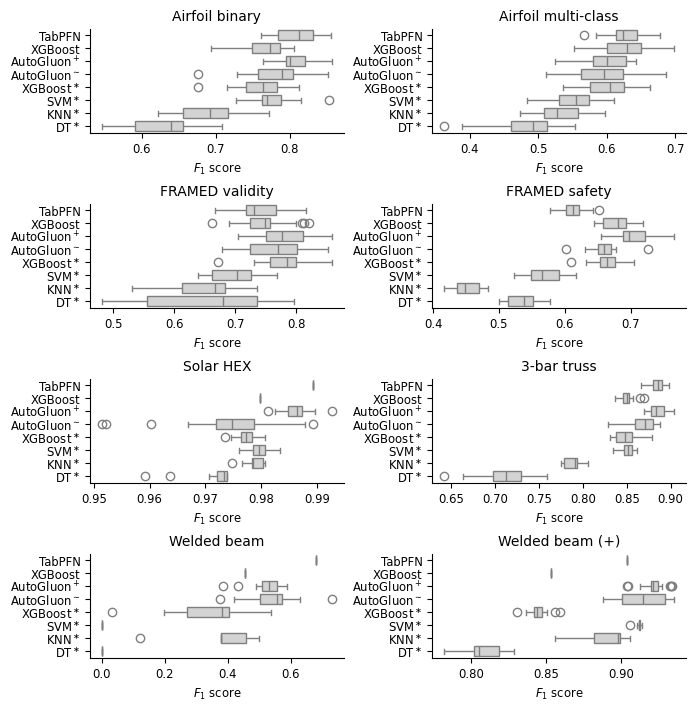

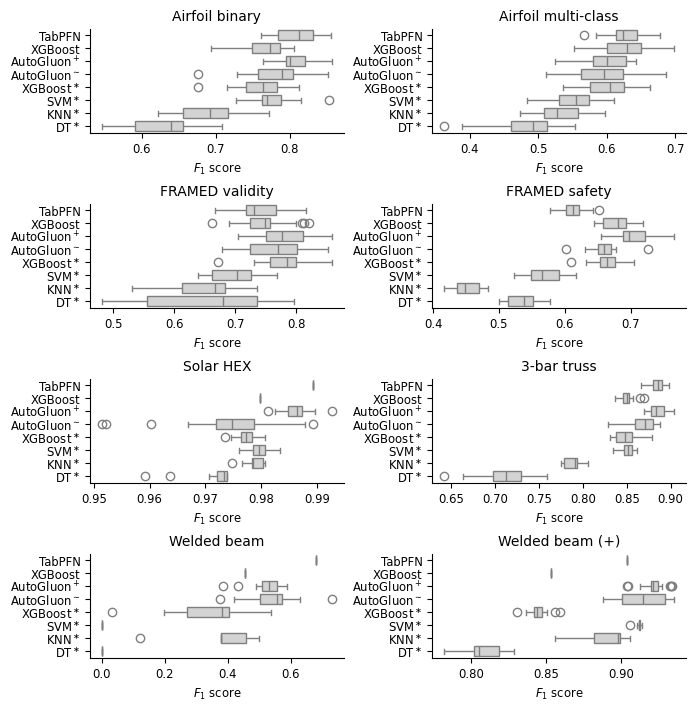

In [30]:
with mpl.rc_context(
    {
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
):
    field = "f1"
    fig, axs = plt.subplots(
        4, 2, figsize=(full_width, 7), sharex=False, sharey=False, layout="constrained",
    )
    for i, dataset in enumerate(dataset_names.keys()):
        ax = axs.flat[i]
        l_data = results.loc[
            (results.trainset_fraction >= 1) &
            results.model.isin(model_names.keys()) & results.dataset.isin([dataset])
        ]

        sns.boxplot(
            data=l_data.replace({"dataset": dataset_names, "model": model_names}),
            x=field,
            y="model",
            ax=ax,
            order=model_names.values(),
            color="lightgray",
        )
        ax.yaxis.label.set_visible(False)
        ax.set_xlabel("$F_1$ score")
        ax.set_title(dataset_names[dataset])

    sns.despine()
    if save_fig:
        fig.savefig("figures/boxplot_f1_fraction_10.pdf", bbox_inches="tight")
        fig.savefig("figures/boxplot_f1_fraction_10.eps", bbox_inches="tight")
fig

In [33]:
auc = (
    results.sort_values("trainset_fraction")
    .groupby(["dataset", "model", "i"])
    .apply(
        lambda x: pd.Series(
            {
                "auc_perf": integrate.trapezoid(x.f1, x.trainset_fraction),
                "auc_speed": integrate.trapezoid(x.total_time, x.trainset_fraction),
            }
        )
    )
    .reset_index()
)

In [35]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def nds_rank(x):
    _, ranks = NonDominatedSorting().do(
        x[["auc_perf", "auc_speed"]].values * [-1, 1], return_rank=True
    )
    x.loc[:, "nds_rank"] = ranks
    return x

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


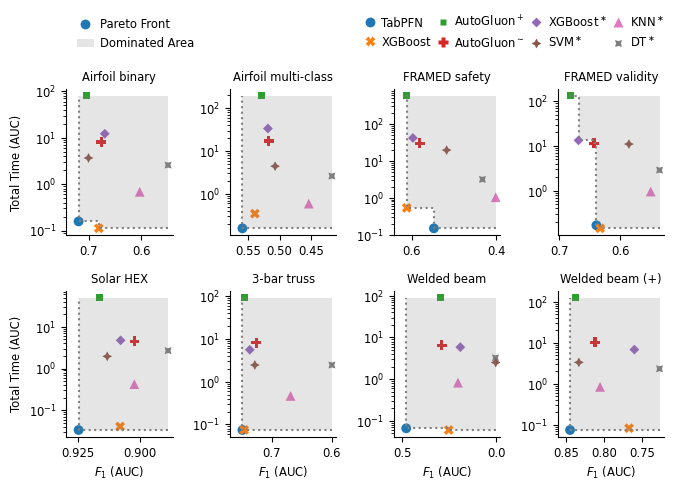

In [37]:
from adjustText import adjust_text

auc_plot_data = auc.groupby(["dataset", "model"]).median().reset_index()
auc_plot_data = auc_plot_data.groupby(["dataset"], group_keys=False).apply(nds_rank)
auc_plot_data["alpha"] = auc_plot_data.nds_rank.apply(lambda x: 1.0 if x == 1 else 0.5)


def annotate(data, **kwargs):
    ax = plt.gca()
    texts = []
    print(data.shape)
    for _, row in data.iterrows():
        texts.append(
            ax.text(
                row.auc_perf,
                row.auc_speed,
                row.model,
                fontsize="8",
                ha="center",
                va="center",
            )
        )

def annotate_best_rank(data, **kwargs):
    ax = plt.gca()
    ax.invert_xaxis()
    xlim = ax.get_xlim()
    ax.set_xlim((xlim[0] + (xlim[0] - xlim[1]) * 0.08, xlim[1]))
    bests = data.loc[data.nds_rank == data.nds_rank.min()].sort_values("auc_perf")
    points = bests[["auc_perf", "auc_speed"]].drop_duplicates().values
    points_list = points.tolist()
    # Create steps between points
    for i in range(len(points) - 1):
        points_list.insert(2 * i + 1, [points[i, 0], points[i + 1, 1]])

    prepend = [[data.auc_perf.min(), data.auc_speed.min()]]
    append = [[data.auc_perf.max(), data.auc_speed.max()]]
    reference = [[data.auc_perf.min(), data.auc_speed.max()]]
    points = np.concatenate([prepend, points_list, append, reference])
    # Fill the area under the curve
    ax.fill(points[:, 0], points[:, 1], alpha=0.2, color="gray", ec="none")
    ax.plot(points[:-1, 0], points[:-1, 1], linestyle="dotted", drawstyle='steps', color="gray")


with mpl.rc_context(
    {
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
):
    fg = sns.FacetGrid(
        auc_plot_data.replace({"model": model_names, "dataset": dataset_names}),
        col="dataset",
        sharey=False,
        sharex=False,
        col_wrap=4,
        height=2.2,
    )
    fg.set_titles("{col_name}")
    fg.map_dataframe(
        sns.scatterplot,
        x="auc_perf",
        y="auc_speed",
        s=50,
        hue="model",
        style="model",
        style_order=list(model_names.values()),
        hue_order=list(
            model_names.values(),
        ),
        ec="none",
    )
    fg.set_ylabels("Total Time (AUC)")
    fg.set_xlabels("$F_1$ (AUC)")
    fg.set(yscale="log")

    fg.figure.set_figwidth(full_width)

    fg.map_dataframe(annotate_best_rank)

    # Add legend with labels on 4 columns at the top of the fourth axis
    ax = fg.axes[3]
    ax.legend(
        bbox_to_anchor=(1.1, 1.2),
        loc="lower right",
        ncol=4,
        frameon=False,
        fontsize="small",
        columnspacing=0.5,
        handletextpad=0.5,
        handlelength=1.0,
    )

    ax = fg.axes[0]
    ax.legend(
        [ax.lines[0], ax.patches[0]],
        ["Pareto Front", "Dominated Area"],
        bbox_to_anchor=(0, 1.2),
        loc="lower left",
        frameon=False,
        fontsize="small",
        columnspacing=0.5,
        handletextpad=0.5,
        handlelength=1.5,
    )

    if save_fig:
        fg.fig.savefig("figures/auc_tt_vs_f1.pdf", bbox_inches="tight")
        fg.fig.savefig("figures/auc_tt_vs_f1.eps", bbox_inches="tight")

In [39]:
def sample_size_for_performance(x, level=0.9):
    pivot_f1 = x.pivot(index="trainset_size", columns="model", values="f1")
    max_f1 = pivot_f1.max().max()

    norm = pivot_f1 / max_f1
    threshold = norm >= level

    r_norm = norm[threshold.columns[(threshold).any()]]
    threshold = r_norm >= level
    # Index where threshold is reached
    above = threshold.idxmax()
    # Index from norm.index prior to above
    index_1 = r_norm.index.get_indexer_for(above) - 1
    # Clip index_1 to 0
    index_1[index_1 < 0] = 0
    below = r_norm.index[index_1]

    t2 = above
    t1 = below

    f2 = np.diag(r_norm.loc[above].values)
    f1 = np.diag(r_norm.loc[below].values)

    return t1 + ((level - f1) * (t2 - t1) / (f2 - f1)).fillna(0)

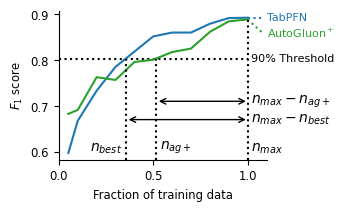

In [40]:
# Figure data efficiency method
with mpl.rc_context(
    {
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
):
    field = "f1"
    fig, ax = plt.subplots(1, 1, figsize=(half_width, 2), layout="constrained")
    l_data = results.loc[
        results.model.isin(["pfn", "gluon_best"])
        & results.dataset.isin(["truss_6d"])
        & (results.i == 10)
    ]

    field_thres = l_data.loc[:, field].max() * 0.9
    ax.plot([0, 1], [field_thres, field_thres], c="k", linestyle=":")
    sns.lineplot(
        data=l_data,
        x="trainset_fraction",
        y=field,
        ax=ax,
        hue="model",
        legend=False,
        hue_order=model_names.keys(),
    )

    ax.set_xlabel("Fraction of training data")
    ax.set_ylabel("$F_1$ score")
    ax.set_xlim(0.0, 1.1)

    pfn_final = l_data.loc[(l_data.trainset_fraction == 1.0) & (l_data.model == "pfn")].f1.values[0]
    gluon_final = l_data.loc[(l_data.trainset_fraction == 1.0) & (l_data.model == "gluon_best")].f1.values[0]

    ax.plot([1.0, 1.08], [pfn_final, pfn_final], c="C0", linestyle=":")
    ax.text(
        1.1,
        pfn_final,
        model_names["pfn"],
        ha="left",
        va="center",
        size=8,
        color="C0",
    )

    ax.plot([1.0, 1.08], [gluon_final, gluon_final-0.03], c="C2", linestyle=":")
    ax.text(
        1.1,
        gluon_final-0.03,
        model_names["gluon_best"],
        ha="left",
        va="center",
        size=8,
        color="C2",
    )

    ax.text(1.02, field_thres, "90% Threshold", va="center", size=8)

    pfn_x = sample_size_for_performance(l_data, 0.9) / dataset_sizes["truss_6d"]

    ax.set_ylim(*ax.get_ylim())

    ax.plot([pfn_x.loc["pfn"], pfn_x.loc["pfn"]], [ax.get_ylim()[0], field_thres], c="k", linestyle=":")
    ax.plot([pfn_x.loc["gluon_best"], pfn_x.loc["gluon_best"]], [ax.get_ylim()[0], field_thres], c="k", linestyle=":")
    ax.plot([1, 1], [ax.get_ylim()[0], field_thres/0.9], c="k", linestyle=":")

    ax.text(pfn_x.loc["pfn"]-0.02, ax.get_ylim()[0]+0.01, "$n_{best}$", ha="right", va="bottom", size=10)
    ax.text(pfn_x.loc["gluon_best"]+0.02, ax.get_ylim()[0]+0.01, "$n_{ag+}$", ha="left", va="bottom", size=10)
    ax.text(1+0.02, ax.get_ylim()[0]+0.01, "$n_{max}$", ha="left", va="bottom", size=10)

    ax.annotate("$n_{max} - n_{best}$", [pfn_x.loc["pfn"], 0.67], [1.02, 0.67], va="center", ha="left", size=10, arrowprops=dict(arrowstyle="<->", color="k", shrinkA=2.0, shrinkB=2.0))
    ax.annotate("$n_{max} - n_{ag+}$", [pfn_x.loc["gluon_best"], 0.71], [1.02, 0.71], va="center", ha="left", arrowprops=dict(arrowstyle="<->", color="k", shrinkA=2.0, shrinkB=2.0))

sns.despine()
if save_fig:
    fig.savefig("figures/data_efficiency_def.pdf", bbox_inches="tight")
    fig.savefig("figures/data_efficiency_def.eps", bbox_inches="tight")
plt.show()

In [41]:
frac90_b = (
    results.loc[results.model.isin(model_names.keys())]
    .groupby(["dataset", "i"])
    .apply(sample_size_for_performance, level=0.90)
    .reset_index()
)
frac90_mc = frac90_b.groupby(["dataset", "model"])[0].agg(["mean", "count"])

frac90_mc["efficiency"] = (
    frac90_b.set_index(["dataset", "model", "i"])
    .apply(lambda x: 1 - x[0] / dataset_sizes[x.name[0]], axis=1)
    .reset_index()
    .pivot(index=["dataset", "model"], columns="i", values=0)
    .fillna(0)
    .mean(axis=1)
)


def relative(x):
    x0_min = x[0].min()
    x[0] = 1 - (x[0] - x0_min) / (dataset_sizes[x.name[0]] - x0_min)
    return x


frac90_mc["efficiency_rel"] = (
    frac90_b.groupby(["dataset", "i"], group_keys=False)
    .apply(relative)
    .pivot(index=["dataset", "model"], columns="i", values=0)
    .fillna(0)
    .mean(axis=1)
)

frac90_mc["mean"] = frac90_mc["mean"].round().astype(int)

In [42]:
frac90_mc

mean  count  efficiency  \
dataset              model                                        
airfoil_cl           bo_knn              630      8    0.115701   
                     bo_svm              315     20    0.644949   
                     bo_xgb              493     17    0.377195   
                     gluon_best          337     20    0.620180   
                     gluon_medium        425     20    0.520051   
                     pfn                 212     20    0.761262   
                     xgb_default         546     19    0.364070   
airfoil_cl_m         bo_knn              704      2    0.020556   
                     bo_svm              409      7    0.188269   
                     bo_xgb              580     18    0.310873   
                     gluon_best          531     18    0.360795   
                     gluon_medium        527     19    0.384463   
                     pfn                 385     19    0.536838   
                     xgb_default         491     20    0.445581   
framed_safety        bo_xgb             1597     20    0.506346   
                     gluon_best         1190     20    0.632224   
                     gluon_medium       1806     17    0.375637   
                     pfn                2121      3    0.051707   
                     xgb_default        1291     20    0.600995   
framed_validity      bo_decision_trees  2351     17    0.296394   
                     bo_svm             2627      8    0.108816   
                     bo_xgb             1324     20    0.633253   
                     gluon_best         1188     20    0.670829   
                     gluon_medium       1649     20    0.543167   
                     pfn                2235     19    0.361625   
                     xgb_default        2293     19    0.346297   
solar_hex            bo_decision_trees    66     20    0.867516   
                     bo_knn               70     20    0.860154   
                     bo_svm               40     20    0.919061   
                     bo_xgb               50     20    0.900901   
                     gluon_best           46     20    0.907130   
                     gluon_medium         54     20    0.891711   
                     pfn                  37     20    0.926063   
                     xgb_default          54     20    0.891720   
truss_6d             bo_knn              987      1    0.000657   
                     bo_svm              525     20    0.475232   
                     bo_xgb              456     20    0.543774   
                     gluon_best          461     20    0.538605   
                     gluon_medium        533     20    0.467190   
                     pfn                 371     20    0.629139   
                     xgb_default         418     20    0.581534   
welded_beam          gluon_best         1785      1    0.005379   
                     gluon_medium       1690      5    0.038766   
                     pfn                1225     20    0.387466   
welded_beam_balanced bo_decision_trees  1736      2    0.030550   
                     bo_knn              767     20    0.693025   
                     bo_svm              414     20    0.834316   
                     bo_xgb             1638     19    0.327506   
                     gluon_best          436     20    0.825589   
                     gluon_medium        685     20    0.725879   
                     pfn                 240     20    0.904167   
                     xgb_default        1503     20    0.398847   

                                        efficiency_rel  
dataset              model                              
airfoil_cl           bo_knn                   0.138963  
                     bo_svm                   0.813449  
                     bo_xgb                   0.492093  
                     gluon_best               0.783281  
                     gluon_medium             0.667941  
                     p

In [43]:
frac90 = (
    frac90_mc["efficiency_rel"]
    .reset_index()
    .pivot(index="model", columns="dataset")
    .fillna(0.0)
    .loc[list(model_names.keys())]
)
frac90.columns = frac90.columns.droplevel(0).map(dataset_names)
frac90.index = frac90.index.map(model_names)
frac90["Average"] = frac90.mean(axis=1)
print(frac90.style.format("{:.1%}", escape="latex").to_latex())

\begin{tabular}{lrrrrrrrrr}
dataset & Airfoil binary & Airfoil multi-class & FRAMED safety & FRAMED validity & Solar HEX & 3-bar truss & Welded beam & Welded beam (+) & Average \\
model &  &  &  &  &  &  &  &  &  \\
TabPFN & 95.6% & 85.5% & 7.0% & 52.4% & 99.0% & 96.5% & 100.0% & 99.6% & 79.4% \\
XGBoost & 45.7% & 71.5% & 84.8% & 48.8% & 95.4% & 89.1% & 0.0% & 44.1% & 59.9% \\
AutoGluon$^+$ & 78.3% & 53.7% & 91.8% & 96.0% & 97.0% & 82.2% & 1.0% & 91.1% & 73.9% \\
AutoGluon$^\sim$ & 66.8% & 60.1% & 50.2% & 77.3% & 95.3% & 70.9% & 12.3% & 80.1% & 64.1% \\
XGBoost$^\ast$ & 49.2% & 47.8% & 70.6% & 90.8% & 96.3% & 83.3% & 0.0% & 36.0% & 59.3% \\
SVM$^\ast$ & 81.3% & 27.0% & 0.0% & 15.5% & 98.3% & 72.9% & 0.0% & 92.0% & 48.4% \\
KNN$^\ast$ & 13.9% & 3.8% & 0.0% & 0.0% & 92.0% & 0.1% & 0.0% & 76.5% & 23.3% \\
DT$^\ast$ & 0.0% & 0.0% & 0.0% & 42.7% & 92.8% & 0.0% & 0.0% & 3.4% & 17.4% \\
\end{tabular}

